In [6]:
from PIL import Image, ImageChops
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy as sp
import scipy.stats as st
%matplotlib inline

In [7]:
def gkern(kernlen_x=21,kernlen_y=21, nsig_x=3, nsig_y=4):
    """Returns a 2D Gaussian kernel array."""

    interval_x = (2*nsig_x+1.)/(kernlen_x)
    interval_y = (2*nsig_y+1.)/(kernlen_y)
    x = np.linspace(-nsig_x-interval_x/2., nsig_x+interval_x/2., kernlen_x+1)
    y = np.linspace(-nsig_y-interval_y/2., nsig_y+interval_y/2., kernlen_y+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.diff(st.norm.cdf(y))
    kernel_raw = np.sqrt(np.outer(kern1d, kern2d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

In [8]:
backgrounds = []
with open('data/background_list_new.txt','r') as f:
    for line in f:
        filename = line.strip()
        backgrounds.append(filename)

faces = []
with open('data/crop_list.txt') as f:
    for line in f:
        filename = line.strip()
        faces.append(filename[1:])
        
num_back = len(backgrounds)
num_faces = len(faces)

In [9]:
def place_face(face_img, back_img, ground_truth=None):
    scaling_factor = np.min([back_img.size[0] / face_img.size[0], back_img.size[1] / face_img.size[1]])
    scale =  (np.random.rand(1)*5 + 2) /  scaling_factor 
    face_img = face_img.resize((face_img.size[0] // scale, face_img.size[1] // scale))
    back_rand = np.random.rand(2) * num_back
    mask = gkern(face_img.size[1], face_img.size[0], 2, 2.5)
    mask = mask/np.max(mask)
    th = (np.mean(mask) - 1*np.std(mask)) 
    mask[mask<th] = 0
    mask[mask>=th] = 255
    mask_img = Image.fromarray(np.uint8(mask))
    back_size = back_img.size
    pos_x = int(np.random.rand(1) * (back_img.size[0] - face_img.size[0]))
    pos_y = int(np.random.rand(1) * (back_img.size[1] - face_img.size[1]))
    old_img = back_img.copy()
    back_img.paste(face_img, (pos_x, pos_y), mask_img)
    #print(mask_img.size, face_img.size, back_img.size)
    if ground_truth is None:
        ground_truth = np.zeros(back_img.size).T
    ground_truth[pos_y:pos_y+face_img.size[1], pos_x:pos_x+face_img.size[0]] = mask
    return back_img, ground_truth

In [ ]:
for back in backgrounds:
    back_img = Image.open('data/' + back)
    for i in range(200):
        no_faces = np.random.randint(1, 6)
        faces_rand = np.random.randint(num_faces, size=(no_faces))
        gnd = None
        out = back_img.copy()
        for face in faces_rand:
            face_img = Image.open('data/' + faces[face])
            out, gnd = place_face(face_img, out, gnd)
        out.save('./data/face_placed/' + back.split('/')[-1][:-4] + '_' + str(i) + '.png')
        np.save('./data/face_placed/' + back.split('/')[-1][:-4] + '_' + str(i) + '_gnd', gnd)

In [ ]:
mask = np.load('./data/face_placed_gnd/0000047_4_gnd.npy')
pic = Image.open('./data/face_placed/0000047_4.png')
fig, ax = plt.subplots(1, 2)
ax[0].imshow(mask)
ax[1].imshow(pic)

In [15]:
placed = []
with open('./data/face_placed/face_placed_list.txt') as f:
    for line in f:
        filename = line.strip()
        placed.append(filename)

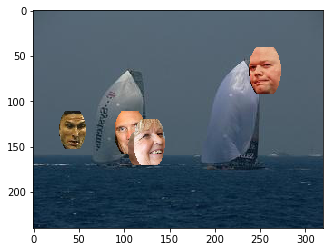

In [22]:
img = Image.open('./data/face_placed/' + placed[10000])
plt.imshow(img)

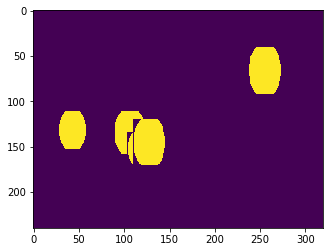

In [24]:
gnd = np.load('./data/face_placed_gnd/' + placed[10000][:-4] + '_gnd.npy')
plt.imshow(gnd)